EJERCICIO 1

La biblioteca dispone de la función train test split, que permite generar una partición de entrenamiento y prueba, y KFold, que genera varias particiones de validaci ́on cruzada.
Estudie el uso de estas funciones y util ́ıcelas parar generar particiones a partir del conjunto de datos Digits que en Scikit-learn puede cargarse usando la función load digits del módulo datasets
Mediante MLPClassifier construya un perceptrón multicapa adecuado para este conjunto de datos y analice su desempeño considerando:
* 1 unica partición de datos genererada mediante train test split,
* 5 particiones generadas mediante KFold,
* 10 particiones generadas mediante KFold.
Para el análisis tenga en cuenta la media y la varianza de la tasa de acierto obtenida en cada partición.

Accuracy con train/test split: 0.9833
Tiempo de entrenamiento y evaluación: 1.2422 segundos


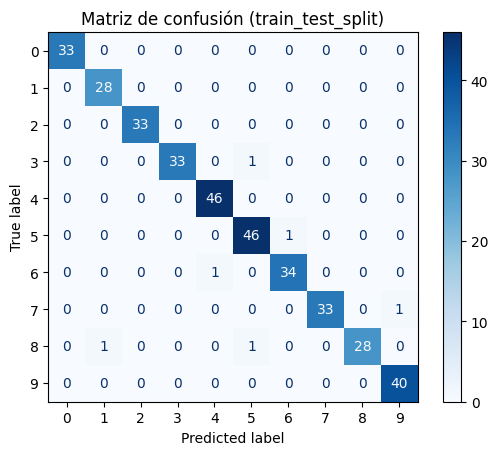

K-Fold (5 splits) - Mean Accuracy: 0.9694, Variance: 0.000053
Tiempo de entrenamiento y evaluación kfold-5: 5.3973 segundos
+------+----------+
| Fold | Accuracy |
+------+----------+
|  1   | 0.972222 |
|  2   | 0.966667 |
|  3   | 0.958217 |
|  4   | 0.980501 |
|  5   | 0.969359 |
+------+----------+


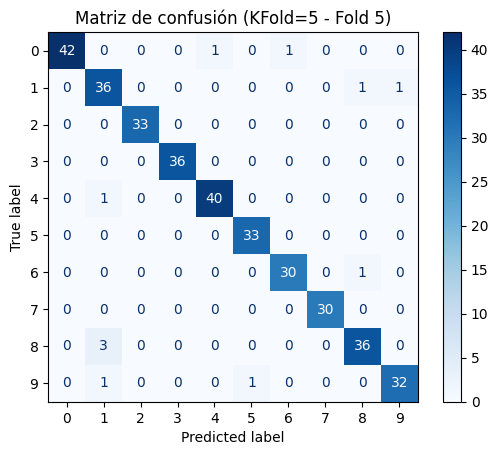

K-Fold (10 splits) - Mean Accuracy: 0.9755, Variance: 0.000082
Tiempo de entrenamiento y evaluación kfold-10: 12.5355 segundos
+------+----------+
| Fold | Accuracy |
+------+----------+
|  1   | 0.988889 |
|  2   | 0.983333 |
|  3   | 0.972222 |
|  4   | 0.955556 |
|  5   | 0.972222 |
|  6   | 0.977778 |
|  7   | 0.977778 |
|  8   | 0.977654 |
|  9   | 0.983240 |
|  10  | 0.966480 |
+------+----------+


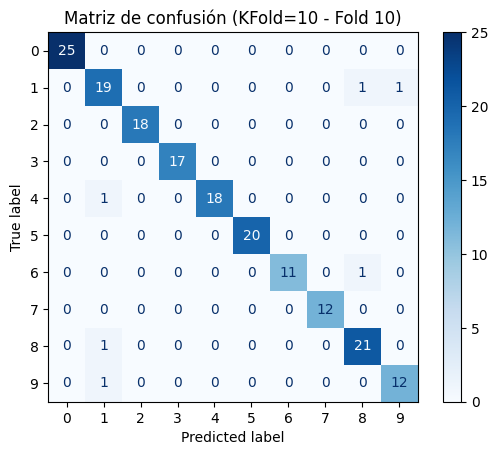

In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPClassifier   
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import time

# ========================
# Cargar dataset
# ========================

digits = load_digits()
x = digits.data
y = digits.target

# ========================
# Definir el clasificador MLP
# ========================
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

# ========================
# 1) Train/Test Split
# ========================

start_time = time.time()  # iniciar contador

x_trn, x_tst, y_trn, y_tst = train_test_split(x, y, test_size=0.2, random_state=42)

mlp.fit(x_trn, y_trn)
y_pred = mlp.predict(x_tst)
acc_split = accuracy_score(y_tst, y_pred)

end_time = time.time()  # detener contador

print(f'Accuracy con train/test split: {acc_split:.4f}')
print(f'Tiempo de entrenamiento y evaluación: {end_time - start_time:.4f} segundos')

# Matriz de confusión
cm = confusion_matrix(y_tst, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión (train_test_split)")
plt.show()

# ========================
# Función para evaluar K-Fold
# ========================
def evaluar_kfold(x, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    cms = []

    for fold_idx, (trn_idx, tst_idx) in enumerate(kf.split(x)):
        x_trn, x_tst = x[trn_idx], x[tst_idx]
        y_trn, y_tst = y[trn_idx], y[tst_idx]

        mlp.fit(x_trn, y_trn)
        y_pred = mlp.predict(x_tst)
        acc = accuracy_score(y_tst, y_pred)
        accuracies.append(acc)

        cm = confusion_matrix(y_tst, y_pred)
        cms.append((fold_idx, cm, y_tst, y_pred))

    mean_acc = np.mean(accuracies)
    var_acc = np.var(accuracies)
    return accuracies, mean_acc, var_acc, cms

# ========================
# 2) K-Fold 5 splits
# ========================
start_time = time.time()
accs_5, mean_acc_5, var_acc_5, cms_5 = evaluar_kfold(x, y, 5)
end_time = time.time()
print(f'K-Fold (5 splits) - Mean Accuracy: {mean_acc_5:.4f}, Variance: {var_acc_5:.6f}')
print(f'Tiempo de entrenamiento y evaluación kfold-5: {end_time - start_time:.4f} segundos')

# Tabla de precisión por fold
table_5 = PrettyTable()
table_5.field_names = ["Fold", "Accuracy"]
for idx, acc in enumerate(accs_5, start=1):
    table_5.add_row([idx, f"{acc:.6f}"])
print(table_5)

#matriz de confusión del último fold
fold_idx, cm, y_tst, y_pred = cms_5[-1]  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Matriz de confusión (KFold=5 - Fold {fold_idx+1})")
plt.show()
# ========================
# 3) K-Fold 10 splits
# ========================
start_time = time.time()
accs_10, mean_acc_10, var_acc_10, cms_10 = evaluar_kfold(x, y, 10)
end_time = time.time()
print(f'K-Fold (10 splits) - Mean Accuracy: {mean_acc_10:.4f}, Variance: {var_acc_10:.6f}')
print(f'Tiempo de entrenamiento y evaluación kfold-10: {end_time - start_time:.4f} segundos')

# Tabla de precisión por fold
table_10 = PrettyTable()
table_10.field_names = ["Fold", "Accuracy"]
for idx, acc in enumerate(accs_10, start=1):
    table_10.add_row([idx, f"{acc:.6f}"])
print(table_10)

#matriz de confusión del último fold
fold_idx, cm, y_tst, y_pred = cms_10[-1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Matriz de confusión (KFold=10 - Fold {fold_idx+1})")
plt.show()


CONCLUSIONES:

* Para train/test split, el modelo se entrena rápidamente y con un error aproximado del 2%, sin embargo, la presición es sensible a la partición inicial del conjunto de datos, por lo tanto el resultado puede estar sesgado si la partición no es representativa del dataset completo (me tocaron casos fáciles y me dió buena accuracy o testee con casos dificiles y me dió baja cuando no todos los casos son así).

* Para la validación cruzada, se divide el conjunto de datos en k subconjuntos, se entrena con k-1 subconjuntos y se usa el restante para testing, por lo que al aumentar k tengo menos datos de prueba, lo que puede aumentar la varianza entre las particiones, pero reduce la sensibilidad a la partición (los subconjuntos son más variables, por lo que es reduce la probabilidad de obtener particiones que provoquen resultados sesgados). También tarda más al aumentar k, porque tiene que evaluar para más particiones